In [ ]:
# To do:
# special thank you to ... 
# create markdown sections (including fMRIPrep website, nilearn website etc.) and put references
# improve comments and add print statements to facilitate human understanding
# add error tests
# 
# load afni files
# load atlas(es) for parcellation (standard and/or data-driven)
#
# Nilearn for FC (normal corr, partial corr or tangent space embedding, the latter of which has been shown to be the best?) 
# Graphpype (from Neuropycon) to calculate graph theory metrics
# Analysis of graph metrics, FC and neuropsych scores etc. using PCA, CCA and then SVM, e.g. ?????????
# 
# hypotheses and contrasts
# significance testing and multiple comparisons correction (e.g. Permutation testing or Hierarchical Bayes??)
# 
# Also check the EverNote notes !!!!!

In [ ]:
# This script is to be used on pre-processed fMRI timeseries data 

In [37]:
import glob
import os

import pandas as pd
import numpy as np
from numpy import mean
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests
import statannot
from statannot import add_stat_annotation

import xlrd
import itertools

from nipype.interfaces import afni
import nibabel as nib
from nilearn import image
from nilearn import plotting
from nilearn import datasets
from nilearn import input_data
from nilearn.input_data import NiftiMapsMasker
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure

import networkx as nx

In [2]:
# import atlas with ROIs to be used for the connectivity analysis

# the MSDL (multi-subject dictionary learning; {cite}Varoquaux_2011) atlas defines a set of probabilistic ROIs across the brain.
# import a different atlas, if you prefer

#msdl_atlas = datasets.fetch_atlas_msdl()

#msdl_coords = msdl_atlas.region_coords
#n_regions = len(msdl_coords)

#print(f'MSDL has {n_regions} ROIs, part of the following networks :\n{np.unique(msdl_atlas.networks)}.')

harv_oxf_atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
rois = harv_oxf_atlas.labels
n_regions = len(rois)
print(f'This atlas has {n_regions} ROIs.')

#
#
# CHECK HOLIGA ET AL.'S PAPER !!!!!!!!!!!!!!!!

This atlas has 49 ROIs.


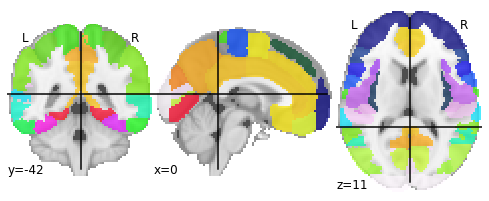

In [3]:
# view the atlas
# plotting.plot_prob_atlas(msdl_atlas.maps)
plotting.plot_roi(harv_oxf_atlas.maps)

In [4]:
# apply a NiftiMapsMasker as the MSDL atlas is probabilistic
# !! if you're using a deterministic atlas, then use a NiftiLabelsMasker object !!

#masker = input_data.NiftiMapsMasker(
#    msdl_atlas.maps, resampling_target="data",
#    t_r=2, detrend=True,
#    low_pass=0.1, high_pass=0.01).fit()

masker = input_data.NiftiLabelsMasker(
    harv_oxf_atlas.maps, resampling_target="data",
    t_r=2, detrend=True,
    low_pass=0.08, high_pass=0.01).fit()

In [5]:
# load an image:
fmri_image_folder = "/Users/mishodimitrov/Downloads"
fmri_image_path = os.path.join(fmri_image_folder, "F001_A.nii")
fmri_image = nib.load(fmri_image_path)
print(fmri_image.shape)

(55, 65, 55, 182)



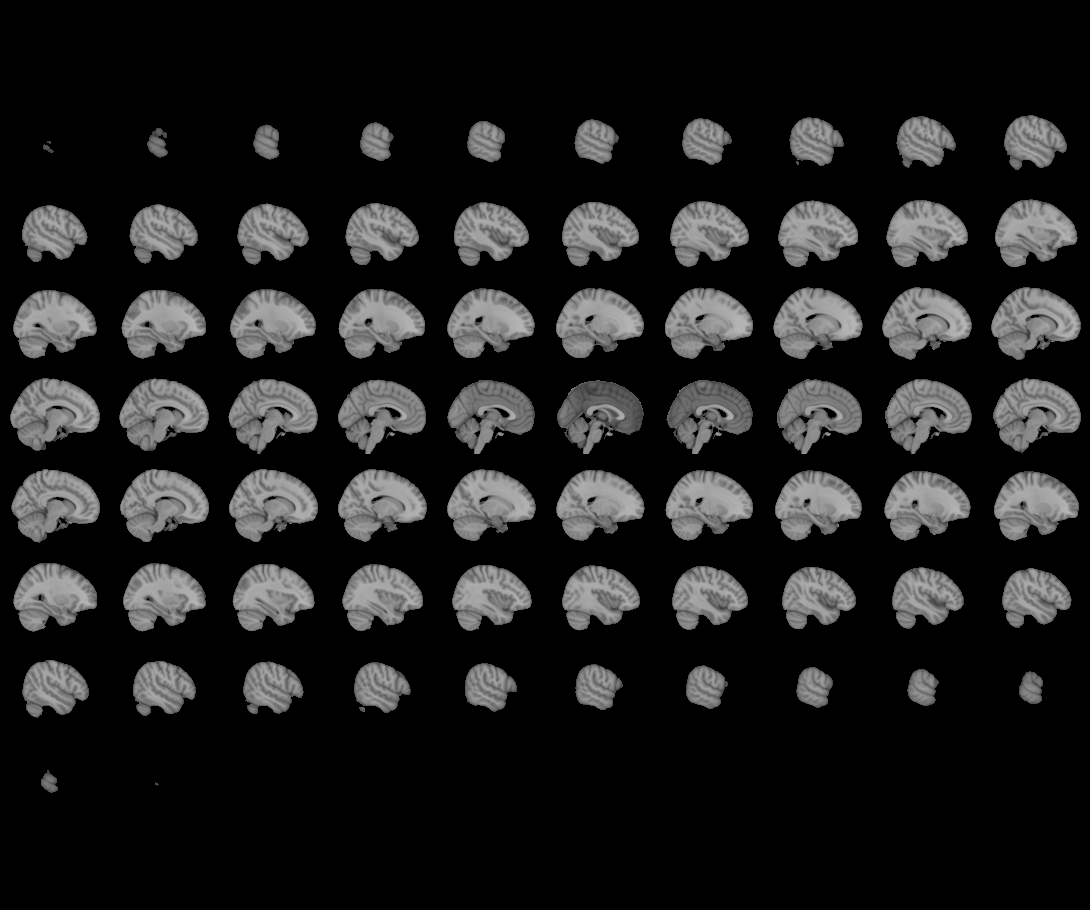
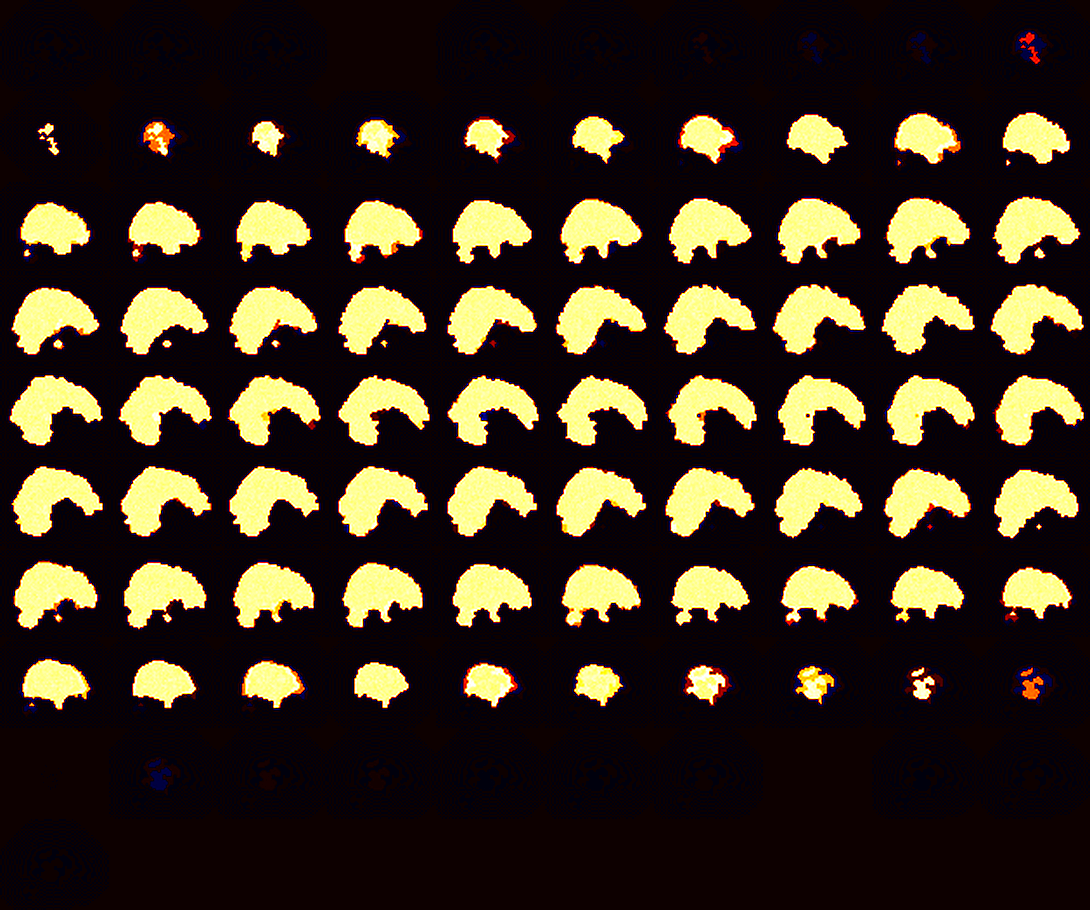

In [6]:
# to look at the mean fMRI brain image for a single participant
# !!!!!!!!!!! ADD THE OTHER LINES !!!!!!!!!!!!!!
# change this line to get your data!
mean_image = image.mean_img(fmri_image)
plotting.view_img(mean_image, threshold=None)

In [7]:
# load the whole dataset
full_fmri_list = sorted(glob.glob("/Users/mishodimitrov/Downloads/*.nii"))
full_fmri_list

['/Users/mishodimitrov/Downloads/F001_A.nii',
 '/Users/mishodimitrov/Downloads/F001_B.nii',
 '/Users/mishodimitrov/Downloads/F002_B.nii',
 '/Users/mishodimitrov/Downloads/F002_C.nii',
 '/Users/mishodimitrov/Downloads/F003_A.nii',
 '/Users/mishodimitrov/Downloads/F003_B.nii',
 '/Users/mishodimitrov/Downloads/F003_C.nii',
 '/Users/mishodimitrov/Downloads/F004_A.nii',
 '/Users/mishodimitrov/Downloads/F004_B.nii',
 '/Users/mishodimitrov/Downloads/F004_C.nii',
 '/Users/mishodimitrov/Downloads/F005_A.nii',
 '/Users/mishodimitrov/Downloads/F005_C.nii',
 '/Users/mishodimitrov/Downloads/F006_A.nii',
 '/Users/mishodimitrov/Downloads/F006_B.nii',
 '/Users/mishodimitrov/Downloads/F006_C.nii',
 '/Users/mishodimitrov/Downloads/F007_B.nii',
 '/Users/mishodimitrov/Downloads/F007_C.nii',
 '/Users/mishodimitrov/Downloads/F008_A.nii',
 '/Users/mishodimitrov/Downloads/F008_B.nii',
 '/Users/mishodimitrov/Downloads/F008_C.nii',
 '/Users/mishodimitrov/Downloads/F009_A.nii',
 '/Users/mishodimitrov/Downloads/F

In [12]:
# !!!!!!!!!!!!!!!!!!!!!!!!!! TEST THIS !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# calculate the connectivity matrices (across the brain) for all participants

def calc_conn(full_fmri_list):
    # specify for the number of participants you have
    for n in range(len(full_fmri_list)):
        # check if this is the right participant
        print("Working on participant:")
        print(full_fmri_list[n])
        
        # !!!!!! change this line to get your data !!!!!!!
        # !! it is recommended to remove confounds by using the confounds= option and selecting them from your confounds file
        # it is also a good idea to compare the corrected and uncorrected connectivity matrices
        roi_time_series = masker.transform(full_fmri_list[n])        
        # calculate a connectivity matrix
        
        # !!!!!!!!! choose a type of correlation analysis, tangent space embedding is recommended, 
        # but it requires that the program is run on all subjects simultaneously !!!!!!!!!!!!!!
        correlation_measure = ConnectivityMeasure(kind=
                                                  #
                                                  #
                                                  # CHECK THE HOLIGA ET AL. PAPER !!!!!!!!!!!!!!!!!
                                                  #
                                                  #
                                                  'correlation')
        correlation_matrix = correlation_measure.fit_transform([roi_time_series])[0]
        print("Connectivity matrix calculated.")
        
        # save the matrix to a csv file, using subject n
        # N.B. matrix file will not have column and row names, i.e. the brain region names. 
        # They have to be added from the atlas that was used for the connectivity analysis when doing the plotting, for instance
        np.savetxt('ARB_sub_'+str(n)+'_conn_matrix.csv', correlation_matrix, delimiter=',')
        print('Connectivity matrix for sub'+str(n)+' saved.')
    print("Done.")


In [13]:
calc_conn(full_fmri_list)

Working on participant:
/Users/mishodimitrov/Downloads/F001_A.nii
Connectivity matrix calculated.
Connectivity matrix for sub0 saved.
Working on participant:
/Users/mishodimitrov/Downloads/F001_B.nii
Connectivity matrix calculated.
Connectivity matrix for sub1 saved.
Working on participant:
/Users/mishodimitrov/Downloads/F002_B.nii
Connectivity matrix calculated.
Connectivity matrix for sub2 saved.
Working on participant:
/Users/mishodimitrov/Downloads/F002_C.nii
Connectivity matrix calculated.
Connectivity matrix for sub3 saved.
Working on participant:
/Users/mishodimitrov/Downloads/F003_A.nii
Connectivity matrix calculated.
Connectivity matrix for sub4 saved.
Working on participant:
/Users/mishodimitrov/Downloads/F003_B.nii
Connectivity matrix calculated.
Connectivity matrix for sub5 saved.
Working on participant:
/Users/mishodimitrov/Downloads/F004_A.nii
Connectivity matrix calculated.
Connectivity matrix for sub6 saved.
Done.


In [23]:
# import pandas as pd
# import specific correlation matrix csv files
# or the mFC_list file (especially after kernel restart)
conn_matrix = pd.read_csv('/Users/mishodimitrov/Downloads/PhD/Analysis/ARB DC/ARB_sub_1_conn_matrix.csv'
                          , delimiter=',', header=None)
print(conn_matrix)
#print(type(conn_matrix))

          0         1         2         3         4         5         6   \
0   1.000000 -0.490778  0.296652  0.316663  0.379034 -0.021249  0.026070   
1  -0.490778  1.000000 -0.157944 -0.347227 -0.098117 -0.032554  0.137649   
2   0.296652 -0.157944  1.000000  0.546227 -0.072416  0.343535  0.292510   
3   0.316663 -0.347227  0.546227  1.000000  0.145010  0.214802 -0.161318   
4   0.379034 -0.098117 -0.072416  0.145010  1.000000  0.380575 -0.074832   
5  -0.021249 -0.032554  0.343535  0.214802  0.380575  1.000000 -0.083371   
6   0.026070  0.137649  0.292510 -0.161318 -0.074832 -0.083371  1.000000   
7  -0.168410  0.299680  0.093462 -0.182904 -0.220092  0.193645 -0.064297   
8  -0.139260  0.509965  0.058596 -0.214828 -0.201024 -0.008997  0.133991   
9   0.006610  0.035170  0.227359 -0.219292 -0.308839  0.210979  0.056626   
10 -0.114725  0.322252  0.123327 -0.221546 -0.388459  0.028918  0.166026   
11  0.153580 -0.291416  0.380698 -0.003870 -0.323761  0.148464  0.054565   
12 -0.182650

/opt/anaconda3/lib/python3.7/site-packages/nilearn/plotting/matrix_plotting.py:13: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  ax.figure.transFigure).width
/opt/anaconda3/lib/python3.7/site-packages/nilearn/plotting/matrix_plotting.py:21: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  ax.figure.transFigure).height


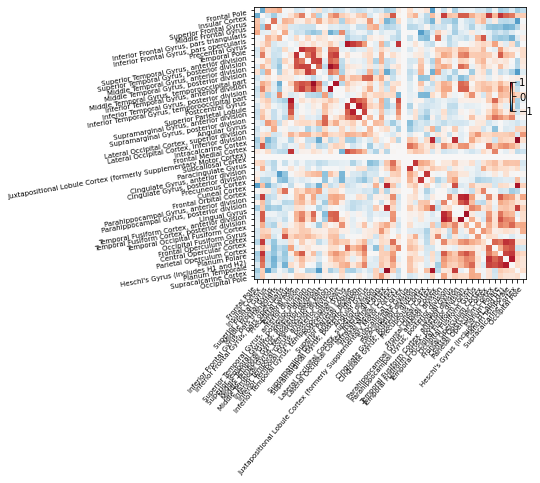

In [24]:
# plot a connectivity matrix
# set this to a matrix of your choice
correlation_matrix = conn_matrix.to_numpy()
np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(correlation_matrix, 
                     # omit the first label as that is the "background" ROI, which wasn't actually used !
                     labels=harv_oxf_atlas.labels[1:],
                     vmax=1, vmin=-1, colorbar=True)

In [ ]:
# Or view it as an embedded connectome:
plotting.view_connectome(correlation_matrix, edge_threshold=0.2,
                         node_coords=msdl_atlas.region_coords)

In [ ]:
# Plot all matrices (get code from the other script)?????

In [ ]:
# Generate summary statistics for both groups (ASD, TD) and all 3 drug conditions??????

In [39]:
# Networkx to calculate degree centrality
#G = nx.Graph()
#G.add_weighted_edges_from(correlation_matrix)

In [27]:
D = nx.Graph(correlation_matrix)
print(D.number_of_nodes())
print(D.number_of_edges())

48
1081


In [ ]:
# 1081 because 48*48-48 gives all non-diagonal values and nx removes the 47 additional 0 values for row 26 = 1081

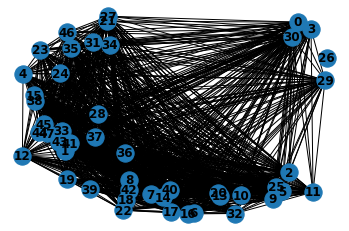

In [36]:
# https://networkx.org/documentation/stable/tutorial.html#drawing-graphs
plt.subplot(111)
nx.draw(D, with_labels=True, font_weight='bold')

In [ ]:
# threshold connectivity matrix to > 0.25
# use the thresholded values as weighted edges for the nx graph
# change the labels (0-47) to the names of the anatomical regions (requires a dictionary with the old and new labels)

In [ ]:
# calculate DC - https://networkx.org/documentation/stable//reference/algorithms/centrality.html

In [ ]:
# plot DC results using the brain atlas coordinates and anatomical labels.. use nilearn plotting?????????

In [ ]:
# Get all the non-imaging data - clean it up, pre-process it, scale it etc.

In [ ]:
# PCA (and CCA????) for dimensionality reduction 

In [ ]:
# Test the different contrasts

In [ ]:
# Assess the statistical significance